In [1]:
#!/usr/bin/env python3

# Script to compute the gabor pyramid filter outputs for the NSD stimuli

import os
import sys
import importlib
import moten
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import argparse
from skimage import color
from scipy.stats import zscore as zs

print(sys.path)

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from classes.voxelsieve import VoxelSieve
from classes.natspatpred import NatSpatPred
NSP = NatSpatPred()
NSP.initialise()

# predparser = argparse.ArgumentParser(description='Get the predictability estimates for a range of images of a subject')

# predparser.add_argument('start', type=int, help='The starting index of the images to get the predictability estimates for')
# predparser.add_argument('end', type=int, help='The ending index of the images to get the predictability estimates for')
# predparser.add_argument('--subject', type=str, help='The subject to get the predictability estimates for', default=None)
# predparser.add_argument('--filetag', type=str, help='The filetag to append to the end of the saved file', default=None)

# args = predparser.parse_args()

# if args.filetag is None:
#     args.filetag = ""


from funcs.gaborpyr import (
    isotropic_gaussian,
    circle_stim,
    random_dot,
    show,
    cut_corners,
    make_checker,
    plot_filter_locations,
    plot_filter_outputs,
    normalize_output,
    select_filters,
)


['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg']
Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [34]:
start = 0
end = 350
subject = "subj01"
filetag = "TEST"

22312

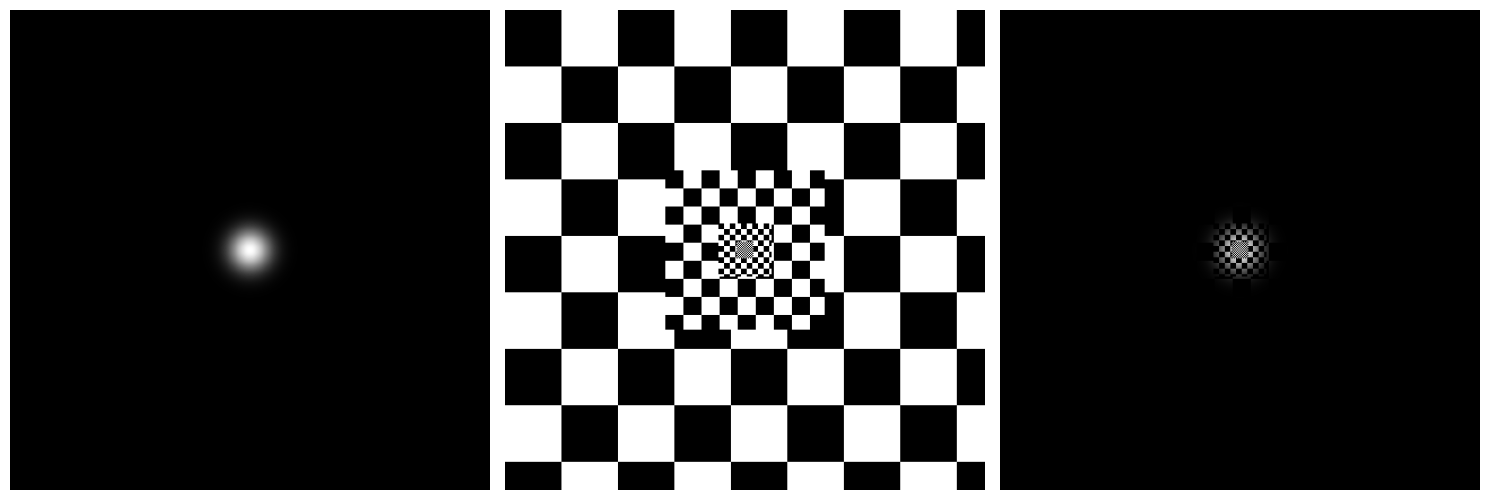

In [4]:


pixels = 425
degrees = 8.4
pix_per_deg = pixels / degrees

cirkel = circle_stim((425, 425), (1 * pix_per_deg), (212, 212))

gauss = isotropic_gaussian(dims=(425,425), sigma=pix_per_deg/4) # Justify this 2.5 factor

checker_stim = make_checker(dims=(425,425), checkercenter=(212,212), scales=3, scaling_factor=3, checker_size=50, stride=0)

fig, axes = plt.subplots(1, 3, figsize=(15,6))

for img_no, img in enumerate([gauss, checker_stim, checker_stim * gauss]):
    axes[img_no].imshow(img, cmap='gist_gray')
    axes[img_no].axis("off")
plt.tight_layout()

gauss_check_stack = np.stack([gauss, checker_stim * gauss], axis=0)

# Original spatfreqs = [0.25, 0.5, 1, 2] in cycles per image (so cycles per 8.4 degrees)
# If I want to transform this to cycles per degree, I need to divide by 8.4
# spat_freqs = [4.2, 8.4, 16.8, 33.6] #### THis was the previous list of spatial frequencies
spat_freqs = [16.8, 33.6] # Extreme option with only 2 spatial frequencies

checkpyramid = moten.pyramids.StimulusStaticGaborPyramid(stimulus=gauss_check_stack,
                                                spatial_frequencies=spat_freqs, # 1, 2, 4, 8 cycles per degree
                                                # spatial_frequencies=[33.6], # 1, 2, 4, 8 cycles per degree
                                                # spatial_orientations=(0, 45, 90, 135),
                                                spatial_orientations=tuple(range(0, 180, 45)),
                                                sf_gauss_ratio=.25, # ratio of spatial frequency to gaussian s.d.
                                                max_spatial_env=(1/8.4), # max sd of gaussian envelope
                                                filter_spacing=2,
                                                include_edges=False, # Should be false, we're not interested in the edges
                                                spatial_phase_offset=0,)

checkpyramid.view.nfilters

In [5]:

### THis is important code for the direction filtering

# Get all directions
directions = [checkpyramid.view.filters[i]['direction'] for i in range(checkpyramid.view.nfilters)]

# Get unique directions
unique_directions = np.unique(directions)

# Initialize an empty array to store the masks
direction_masks = np.zeros((len(unique_directions), checkpyramid.view.nfilters), dtype=bool)

# Create a mask for each unique direction
for i, direction in enumerate(unique_directions):
    direction_masks[i] = np.array(directions) == direction
    
# Check if there's still a file with the filter selection, saves time

file_exists = os.path.isfile(f"{NSP.own_datapath}/visfeats/gabor_pyramid/gauss_checker_output_{filetag}.npy")

if file_exists:
    print("Loading the filter selection from file")
    gauss_output = np.load(f"{NSP.own_datapath}/visfeats/gabor_pyramid/gauss_checker_output_{filetag}npy")
else:
    gauss_output = checkpyramid.project_stimulus(gauss_check_stack)

# Figure out how many filters there are per spatial frequency
filters_per_freq= []
for sf in spat_freqs:

    all_filters = checkpyramid.view.filters
    count = sum(1 for d in all_filters if d.get('spatial_freq') == sf)
    filters_per_freq.append(count)
    
filters_per_freq

output_norm, filters_per_freq_sel, filter_selection, filter_selection_dictlist = (
    select_filters(
        pyramid=checkpyramid,
        output=gauss_output,
        imgs=gauss_check_stack,
        img_no=1,
        spat_freqs=spat_freqs,
        direction_masks=direction_masks,
        filters_per_freq=filters_per_freq,
        percentile_cutoff=99.5, # Het moet maar
        plot=False,
        verbose=True,
    )
)

# Stack the directions
full_filter = np.sum(np.array(filter_selection), axis=0)


# The indices for the filters that are within the patch
filter_indices = np.where(full_filter == True)[0]




project_stimulus: 100%|██████████| 22312/22312 [05:07<00:00, 72.67it/s]


Direction 0, Spatial frequency 0: percentile = 0.6747756630182281, number of values > percentile = 22
Direction 0, Spatial frequency 1: percentile = 0.5623852610588074, number of values > percentile = 62
Direction 1, Spatial frequency 0: percentile = 0.7047730684280396, number of values > percentile = 21
Direction 1, Spatial frequency 1: percentile = 0.5620825290679932, number of values > percentile = 57
Direction 2, Spatial frequency 0: percentile = 0.6747756630182281, number of values > percentile = 22
Direction 2, Spatial frequency 1: percentile = 0.5623852610588074, number of values > percentile = 62
Direction 3, Spatial frequency 0: percentile = 0.6598773449659764, number of values > percentile = 22
Direction 3, Spatial frequency 1: percentile = 0.5621248483657837, number of values > percentile = 61
Direction 0: Filter includes 84 out of 22312 filters
Direction 1: Filter includes 78 out of 22312 filters
Direction 2: Filter includes 84 out of 22312 filters
Direction 3: Filter inclu

In [35]:
# Now we can project the NSD images

start_img = start
end_img = end

# FOR NOW I DEFINE THE SUBJECT BECAUSE I WANT TO CHECK THE PERFORMANCE
# OF THE MODEL BEFORE COMPUTING IT FOR THE 73K IMAGES
imgs,_ = NSP.stimuli.rand_img_list(n_imgs=(end_img-start_img), 
                                   asPIL=False, 
                                   add_masks=False, 
                                   select_ices=NSP.stimuli.imgs_designmx()[subject][start_img:end_img])

img_list = []

print("Converting images to luminance channel")
for img_no, img in enumerate(imgs):

    # Convert RGB image to LAB colour space
    lab_image = color.rgb2lab(imgs[img_no])

    # First channel [0] is Luminance, second [1] is green-red, third [2] is blue-yellow
    lumimg = lab_image[
        :, :, 0
    ]  # Extract the L channel for luminance values, assign to input array

    img_list.append(lumimg)

imgstack = np.array(img_list)

Converting images to luminance channel


In [36]:
imgstack.shape

(350, 425, 425)

In [37]:

# spat_freqs = [4.2, 8.4, 16.8, 33.6]
directions = tuple(range(0, 180, 45))

nsdpyramid = moten.pyramids.StimulusStaticGaborPyramid(stimulus=imgstack,
                                                spatial_frequencies=spat_freqs, # 1, 2, 4, 8 cycles per degree
                                                # spatial_frequencies=[33.6], # 1, 2, 4, 8 cycles per degree
                                                # spatial_orientations=(0, 45, 90, 135),
                                                spatial_orientations=tuple(range(0, 180, 45)),
                                                sf_gauss_ratio=.25, # ratio of spatial frequency to gaussian s.d.
                                                max_spatial_env=(1/8.4), # max sd of gaussian envelope
                                                filter_spacing=2,
                                                include_edges=False, # Should be false, we're not interested in the edges
                                                spatial_phase_offset=0,)

checkpyramid.view.nfilters

print(f"Ended up with a total filter count of:{np.sum(filters_per_freq_sel)} / {nsdpyramid.view.nfilters}")



Ended up with a total filter count of:329 / 22312


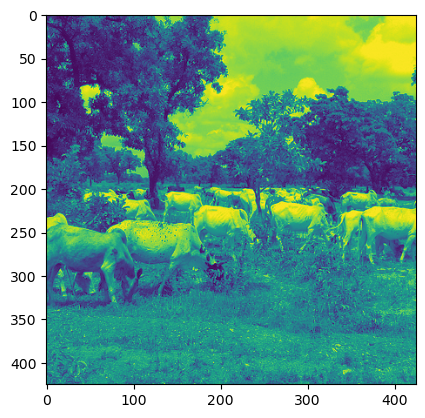

In [25]:
imgstack_2 = imgstack.reshape((100, 425, 425))

imgstack_2.shape

plt.imshow(imgstack_2[0,:,:])

In [38]:
flat_list = [item for sublist in filter_selection_dictlist for item in sublist]


In [39]:
nsd_output = nsdpyramid.project_stimulus(imgstack, filters=flat_list)

project_stimulus: 100%|██████████| 329/329 [00:04<00:00, 66.92it/s]


In [26]:
nsd_output = nsdpyramid.project_stimulus(imgstack_2, filters=flat_list)

project_stimulus: 100%|██████████| 329/329 [00:04<00:00, 71.06it/s]


In [40]:
nsd_output.shape

(350, 329)

In [41]:
filters_per_freq_agg = np.sum(filters_per_freq_sel, axis=0)
print(filters_per_freq_agg)

[ 87 242]


In [61]:
def normalize_output(output, n_spatfreqs, filters_per_freq):
    """
    Normalizes the output of the Gabor pyramid.

    Parameters:
    - output: The output of the Gabor pyramid.

    Returns:
    - The normalized output.
    """
    start = 0
    output_norm = np.zeros_like(output)

    for i in range(n_spatfreqs):
        end = start + filters_per_freq[i]
        output_norm[:, start:end] = zs(output[:, start:end])
        start = end

    return output_norm

In [62]:
nsd_output.shape

(350, 329)

In [64]:
nsd_output_norm = normalize_output(nsd_output, len(spat_freqs), filters_per_freq_agg)

In [65]:
nsd_output_norm.shape

(350, 329)

In [ ]:






filetag_str = f"_{filetag}" if filetag != "" else ""

In [ ]:
os.makedirs(f"{NSP.own_datapath}/visfeats/gabor_pyramid/batches{filetag_str}", exist_ok=True)

np.save(f"{NSP.own_datapath}/visfeats/gabor_pyramid/batches{filetag_str}/gabor_baseline_{filetag_str}{start_img}_{end_img}.npy", nsd_output_norm)

print(f"Saved the output to {NSP.own_datapath}/visfeats/gabor_pyramid/batches{filetag_str}/gabor_baseline_{filetag_str}{start_img}_{end_img}.npy")